In [1]:
import os
import numpy as np
from text_processing.process_data import *
from text_processing.dea import *
from training.train_dev_test import *

import warnings
warnings.filterwarnings('ignore')

## Data Exploratory and Analysis

In [2]:
# paths
files_folder = 'lang_files/'
files_path = os.path.join(os.getcwd(), files_folder)

# initial data
lang_data = compile_all_data(files_path)
lang_data.head()

,sentence,language
0,"Dili, 11 Outubru 2021 - Gabinete Apoiu Ativida...",tet
1,Treinamentu ne’e ninia objetivu prinsipál mak ...,tet
2,Iha loron daruak hosi treinamentu ne’e partisi...,tet
3,Partisipante na’in-56 iha treinamentu ne’e mai...,tet
4,Komunidade iha suku Bikeli ho Makadade agrades...,tet


In [3]:
# after preprocessed and counted each sentence length
clean_data = clean_data_with_count(files_path)
clean_data.head()

,sentence,language,sentence_length
0,dili outubru gabinete apoiu atividade kónju...,tet,274
1,treinamentu ne’e ninia objetivu prinsipál mak ...,tet,229
2,iha loron daruak hosi treinamentu ne’e partisi...,tet,286
3,partisipante na’in iha treinamentu ne’e mai ho...,tet,82
4,komunidade iha suku bikeli ho makadade agrades...,tet,317


In [4]:
# confirm that the data was cleaned.
clean = clean_data[clean_data['sentence'] =='']
try:
    assert len(clean) == 0
    print("The data is cleaned.")
except AssertionError:
    print("The data is not cleaned.")

The data is cleaned.


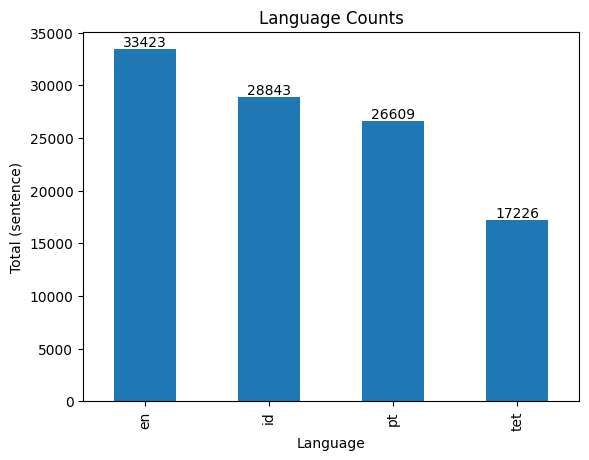

In [5]:
# General data info
display_data_in_bar(clean_data)

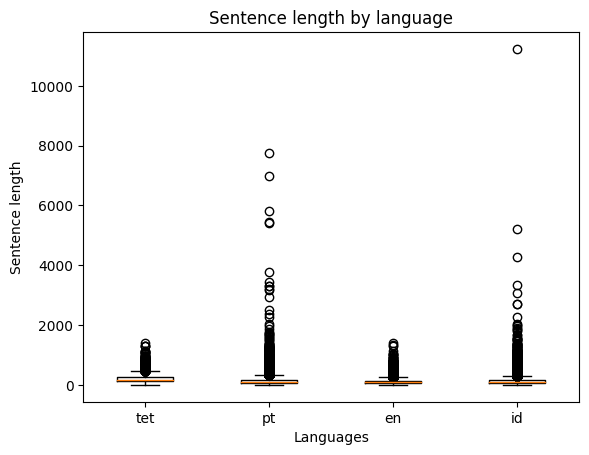

In [6]:
# A plot contains boxplot for each languages
display_data_in_boxplot(clean_data)

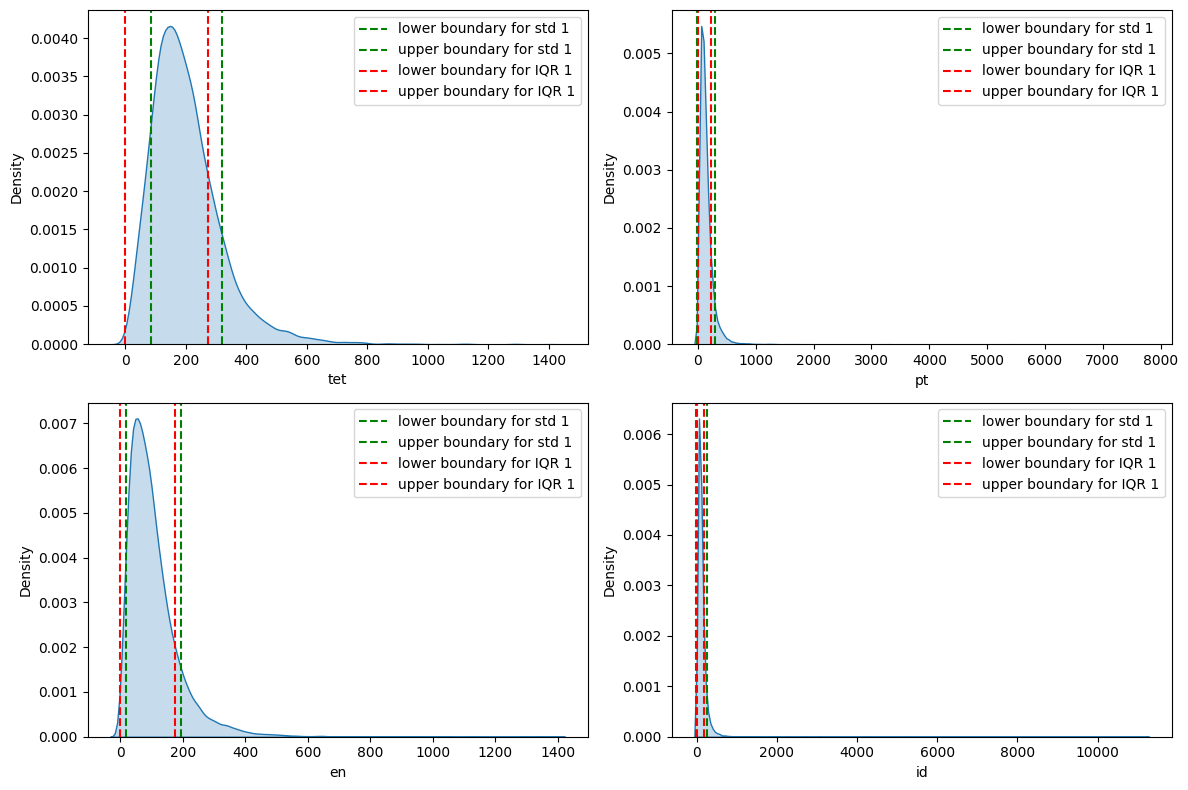

In [7]:
# preview sentence length with Gaussian Distribution
display_data_in_gaussian_dist(clean_data, display_lines=1)

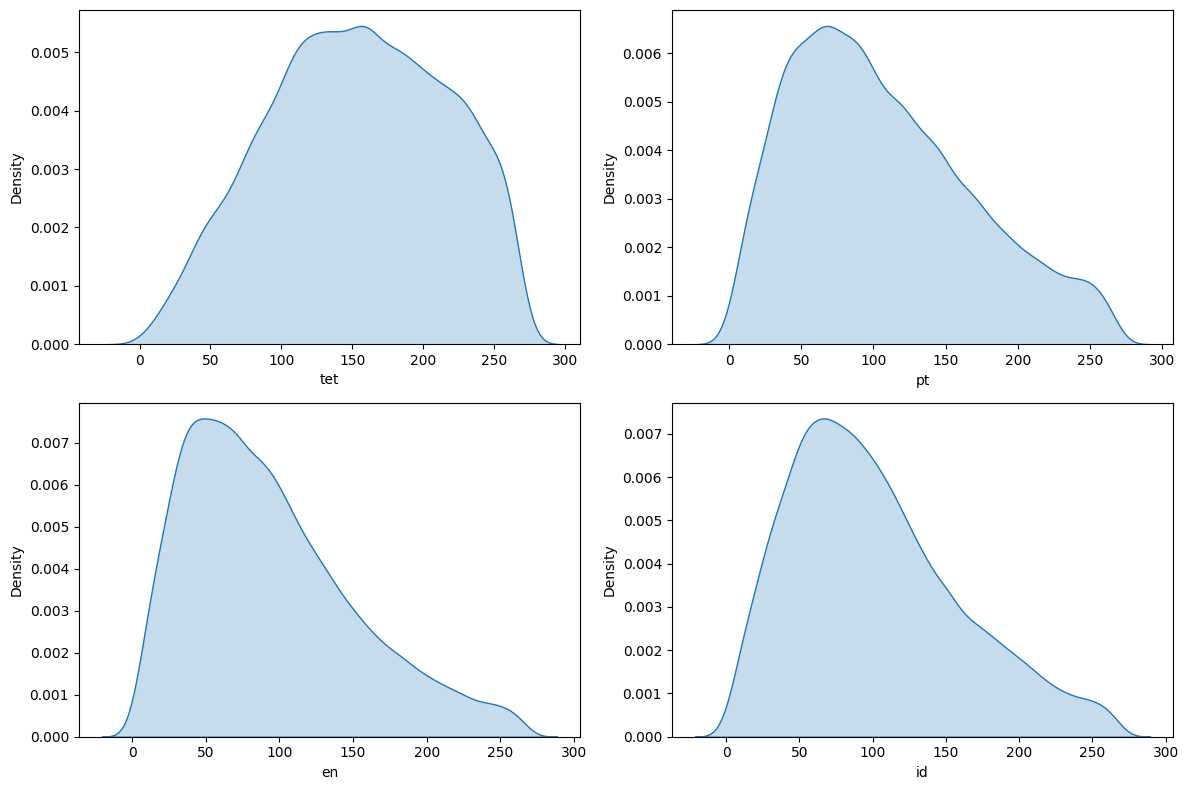

In [8]:
# preview sentence length with Gaussian Distribution after removing outliers
display_data_in_gaussian_dist(clean_data, removed_sentence_outliers, display_lines=0)

In [9]:
# Comparison regarding original data, after removing outliers, and their difference
before = [[len(x)] for x in count_sentences(clean_data)]
after = [[len(x)] for x in removed_sentence_outliers(clean_data)]
difference = [before[i][0] - after[i][0] for i in range(len(before))]
after_removing_outliers = sum([sum(x) for x in after])

print(f"Before removing outliers: {before}\nAfter removing outliers: {after}" )
print(f"Difference (outliers): {difference}\nTotal original data: {len(clean_data)}")
print(f"Total after removing outliers: {after_removing_outliers}\nTotal sentences removed: {sum(difference)}")

Before removing outliers: [[17226], [26609], [33423], [28843]]
After removing outliers: [[13358], [24176], [31787], [26872]]
Difference (outliers): [3868, 2433, 1636, 1971]
Total original data: 106101
Total after removing outliers: 96193
Total sentences removed: 9908


In [10]:
# final clean dataset
final_clean_dataset = final_clean_data(clean_data)
final_clean_dataset.head()

,sentence,language
1,treinamentu ne’e ninia objetivu prinsipál mak ...,tet
3,partisipante na’in iha treinamentu ne’e mai ho...,tet
7,enkuantu jenerál manajer cefobom antoninho dou...,tet
8,manufahi dezembru – eis jornalista rádiu kom...,tet
10,iha fatin hanesan eis jornalista rádiu komunid...,tet


In [11]:
# confirm if the final_clean_data equals to total_data_after_removing_outliers
try:
    assert len(final_clean_dataset) == after_removing_outliers
    print("Test passed.")
except AssertionError:
    print("The total is different.")

Test passed.


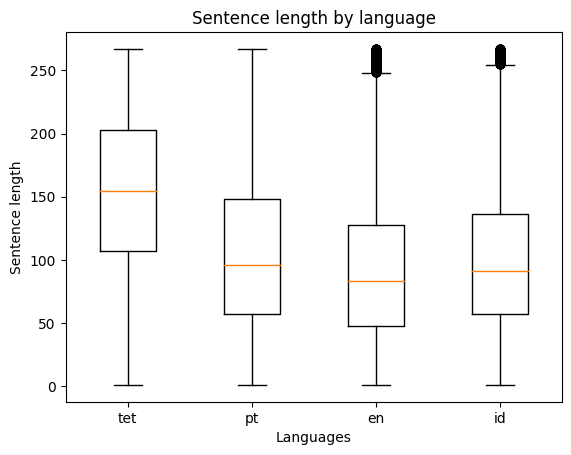

In [12]:
# visualize clean data
display_data_in_boxplot(final_clean_dataset)

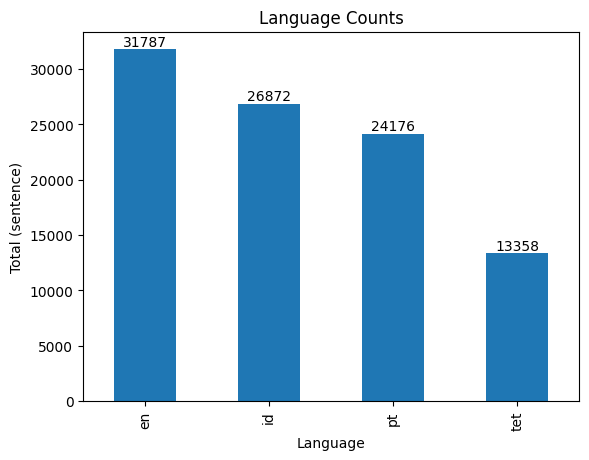

In [13]:
# Clean data info in a bar plot
display_data_in_bar(final_clean_dataset)

In [14]:
# Comparison of the sentences length before and after normalization

# Sentence length
initial_sentence_length = [len(x) for x in clean_data['sentence']]
final_clean_sentence_length = [len(x) for x in final_clean_dataset['sentence']]

# Before normalized
before_sentence_max = np.max(initial_sentence_length)
before_sentence_min = np.min(initial_sentence_length)
before_sentence_avg = np.average(initial_sentence_length)

# After normalized 
after_sentence_max = np.max(final_clean_sentence_length)
after_sentence_min = np.min(final_clean_sentence_length)
after_sentence_avg = np.average(final_clean_sentence_length)

print(f'Sentence max length before normalized: {before_sentence_max} and after normalized: {after_sentence_max}')
print(f'Sentence min length before normalized: {before_sentence_min} and after normalized: {after_sentence_min}')
print(f'Sentence avg length before normalized: {before_sentence_avg: .2f} and after normalized: {after_sentence_avg: .2f}')

Sentence max length before normalized: 11234 and after normalized: 267
Sentence min length before normalized: 1 and after normalized: 1
Sentence avg length before normalized:  134.90 and after normalized:  107.27


## Clustering

In [19]:
# select the dataset fraction for clustering
final_clean_dataset_cluster = final_clean_dataset.sample(frac=0.05, random_state=42)
print('Total: ', len(final_clean_dataset_cluster))

Total:  4810


In [20]:
#Generate plot for each clustering algorithm

#kmeans
display_data_in_clustering(final_clean_dataset_cluster, KMeans, "K-Means", random_state=1)
#gaussian_mixture
display_data_in_clustering(final_clean_dataset_cluster, GaussianMixture, "Gaussian-Mixture", n_components_true=1, random_state=1)
#agglomerative
display_data_in_clustering(final_clean_dataset_cluster, AgglomerativeClustering, "Agglomerative")
# birch
display_data_in_clustering(final_clean_dataset_cluster, Birch, "Birch")

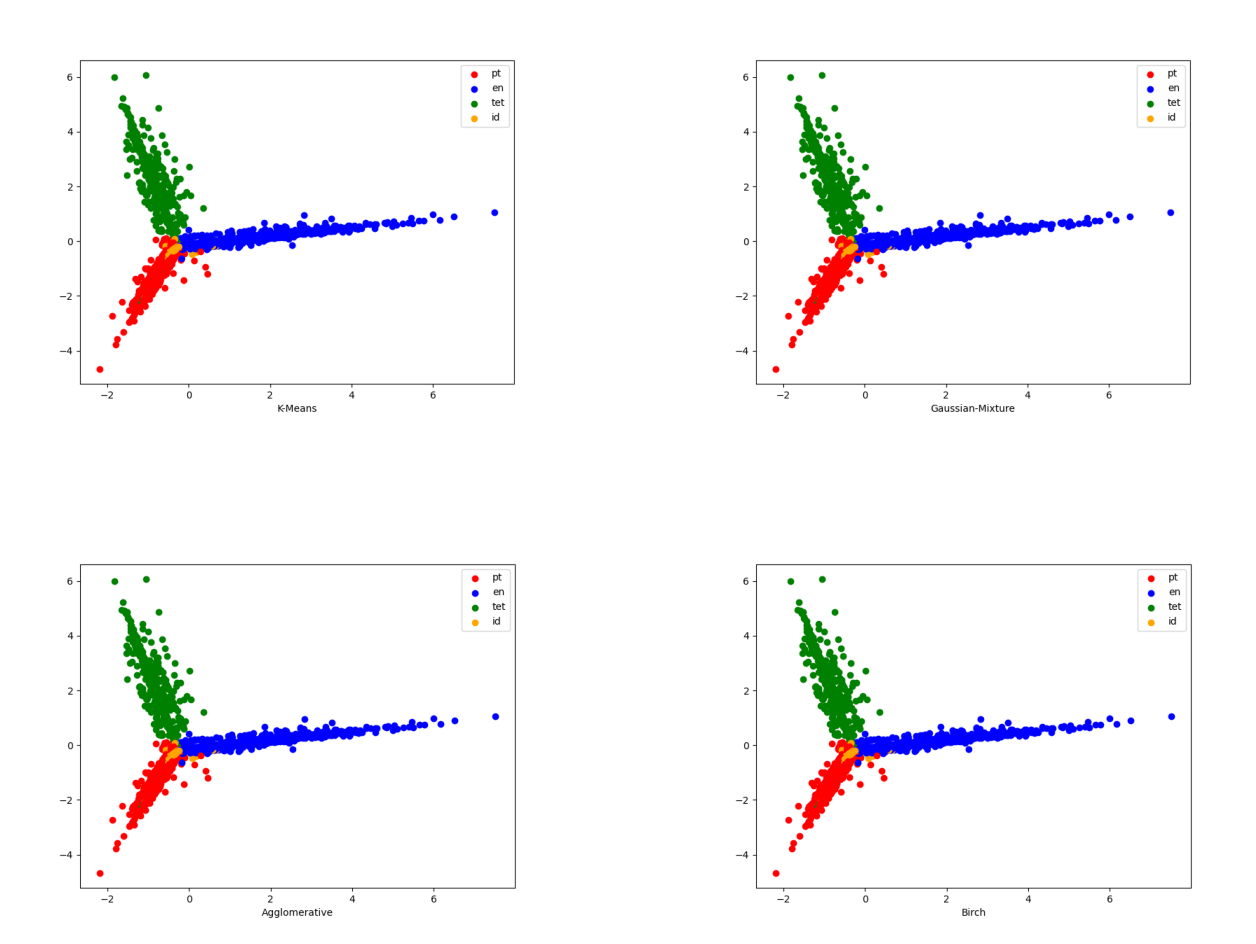

In [2]:
# Compile the plots in an image
display_images("k-means.png", "gaussian-mixture.png", "agglomerative.png", "birch.png")

## Train and test model

### Split dataset

In [16]:
# Split dataset to train, development(dev)/validation, and test sets
X_train, y_train, X_dev, y_dev, X_test, y_test = train_dev_test_split(final_clean_dataset, 0.2, 0.5)

# print the sizes of the resulting sets
print("Train set size:", len(X_train))
print("Dev set size:", len(X_dev))
print("Test set size:", len(X_test))

Train set size: 76954
Dev set size: 9619
Test set size: 9620


### Train and evaluate model

In [18]:
# Train and evaluate the model using dev set

# Models to be compared
    #('svm', LinearSVC())
    #('logistic_reg', LogisticRegression(multi_class='ovr'))
    #('nb', MultinomialNB())

# Train the model
model = train_model(TfidfVectorizer(), MultinomialNB(), X_train, y_train)

# Evaluate the model using dev set
evaluate_model(model,X_dev, y_dev)

Accuracy:  0.9951138371972138
Confusion Matrix:  [[3199    0    2    1]
 [  23 2647    2    1]
 [  10    1 2418    3]
 [   0    0    4 1308]]
Classification Report:                precision    recall  f1-score   support

          en       0.99      1.00      0.99      3202
          id       1.00      0.99      0.99      2673
          pt       1.00      0.99      1.00      2432
         tet       1.00      1.00      1.00      1312

    accuracy                           1.00      9619
   macro avg       1.00      1.00      1.00      9619
weighted avg       1.00      1.00      1.00      9619



### Test model

In [19]:
# Evaluate the model using test set
evaluate_model(model, X_test, y_test)

Accuracy:  0.9949064449064449
Confusion Matrix:  [[3095    2    1    2]
 [  21 2741    0    0]
 [  17    0 2401    2]
 [   3    0    1 1334]]
Classification Report:                precision    recall  f1-score   support

          en       0.99      1.00      0.99      3100
          id       1.00      0.99      1.00      2762
          pt       1.00      0.99      1.00      2420
         tet       1.00      1.00      1.00      1338

    accuracy                           0.99      9620
   macro avg       1.00      0.99      1.00      9620
weighted avg       0.99      0.99      0.99      9620



### Further test

In [20]:
test1 = model.predict(["Organizasaun mundial saude"])
test2 = model.predict(["Tribunál rekursu rejeita kandidatura partidu"])
print(f"Test 1 classification: {test1}\nTest 2 classification: {test2}")

Test 1 classification: ['tet']
Test 2 classification: ['tet']


In [21]:
input = ["Deklarasaun Universál Direitus Umanus", 
        "Indonesia merupakan negara terluas ke-14 sekaligus",
        "A língua portuguesa, também designada português, é uma língua",
        "Deklarasaun ne'e inklui artigu 30 ne'ebé esplika Asembleia Jerál",
        "Can we feed a future population of 10 billion people a healthy?"
        ]

# Naive Bayes and Logistic Regression
pred_probs = model.predict_proba(input)

for i, probs in enumerate(pred_probs):
    print(input[i])
    for j, lang in enumerate(model.classes_):
        print(lang, probs[j])

Deklarasaun Universál Direitus Umanus
en 0.08504233349451248
id 0.0863242370584187
pt 0.08219831011023383
tet 0.7464351193368353
Indonesia merupakan negara terluas ke-14 sekaligus
en 0.0001910157150619629
id 0.9994685019332696
pt 0.00011824261321848722
tet 0.0002222397384508982
A língua portuguesa, também designada português, é uma língua
en 0.002134300904377674
id 0.0022087942878947406
pt 0.9868648079154321
tet 0.008792096892295315
Deklarasaun ne'e inklui artigu 30 ne'ebé esplika Asembleia Jerál
en 4.6716049029742476e-05
id 5.270746586511008e-05
pt 5.0959156924546875e-05
tet 0.9998496173281811
Can we feed a future population of 10 billion people a healthy?
en 0.9997103393756969
id 0.0001304546879447448
pt 9.194918776502556e-05
tet 6.725674859407294e-05


In [ ]:
# SVM - LinearSVC
pred_result = model.predict(input)
pred_probability = model.decision_function(input)
for i in range(len(input)):
    print(f"{input[i]} ---> {pred_result[i]} ---> {np.argmax(pred_probability[i])} --> {pred_probability[i]} ")

### Save model [if required]

In [22]:
import joblib

# save the model to a file
#joblib.dump(model, 'tet-lid-model_NB.pkl')

In [24]:
# load the save model from a file
saved_model = joblib.load('model_best/tet-lid-model_NB.pkl')

In [25]:
from unidecode import unidecode

text = """
𝐋𝐚 𝐏𝐚𝐫𝐭𝐢𝐬𝐢𝐩𝐚 𝐀𝐧𝐢𝐯𝐞𝐫𝐬𝐚𝐫𝐢𝐮 𝐕𝐞𝐭𝐞𝐫𝐚𝐧𝐮 𝐁𝐚 𝐃𝐚𝐥𝐚 𝐕𝐈 𝐗𝐚𝐧𝐚𝐧𝐚: “𝐇𝐚’𝐮 𝐋𝐚 𝐇𝐚𝐥𝐨 𝐁𝐮𝐚𝐭 𝐈𝐝𝐚, 𝐇𝐮𝐬𝐮 𝐁𝐚 𝐉𝐞𝐧𝐞𝐫𝐚𝐥 𝐧𝐨 𝐅𝐮𝐧𝐝𝐚𝐝𝐨𝐫 𝐒𝐢𝐫𝐚, 𝐓𝐚𝐧𝐛𝐚 𝐇𝐚’𝐮 𝐍𝐞’𝐞 𝐒𝐨𝐞𝐡𝐚𝐫𝐭𝐨 𝐊𝐞𝐝𝐮𝐚” 
"""

plain_text = unidecode(text)
plain_text

'\nLa Partisipa Aniversariu Veteranu Ba Dala VI Xanana: "Ha\'u La Halo Buat Ida, Husu Ba Jeneral no Fundador Sira, Tanba Ha\'u Ne\'e Soeharto Kedua" \n'

In [26]:
saved_model.predict([plain_text])

array(['tet'], dtype='<U3')